In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using LinearAlgebra
using Flux, DiffEqFlux
using Optim
using Plots
using ProgressMeter
using Random
using DifferentialEquations: DP5, Tsit5, BS3
using NLopt
ProgressMeter.ijulia_behavior(:clear)

┌ Info: Precompiling QuantumOptimalControl [e91afccf-c93e-44fd-aa4c-3d3ef13645c0]
└ @ Base loading.jl:1423


false

In [2]:
bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) + sigmaz(bs));

In [3]:
V = 2π*24.0
δe = -2π*4.5

-28.274333882308138

In [4]:
n_atoms = 4
bsys = tensor([bs for i in 1:n_atoms]...);

In [5]:
H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]]);

In [6]:
H1 = 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H2 = -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

In [7]:
function GHZ_state(n_atoms)
    state = tensor([spindown(bs)⊗spinup(bs) for i in 1:Int(n_atoms/2)]...) +
            tensor([spinup(bs)⊗spindown(bs) for i in 1:Int(n_atoms/2)]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)

trans = StateTransform(ground_state(n_atoms)=>GHZ_state(n_atoms));

In [8]:
n_neurons = 4
sigmoid(x)= @. 2π*7 / (1 + exp(-x))
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 2))
θ = initial_params(ann)  

n_params = length(θ)
Random.seed!(10)
θ = 2.0*rand(n_params).-1.0

t0, t1 = 0.0, 1.0

coeffs(params, t) = let vals = ann([t], params)
                        [sigmoid(vals[1]), vals[2]]
                    end    

cost = CostFunction((x, y) -> x'*y,
                     p->-2e-3 *(sigmoid(ann([t0], p)[1])^2+ sigmoid(ann([t1], p)[1])^2))

CostFunction(var"#19#21"(), var"#20#22"())

In [9]:
prob = QOCProblem((H0, [H1, H2]), coeffs, trans, (t0, t1), cost);

In [10]:
@time sol = QuantumOptimalControl.optimize(prob, θ, ADAM(0.03), alg=Tsit5(), reltol=1e-6, abstol=1e-6, n_iter=3000)

Progress: 100%|█████████████████████████████████████████| Time: 0:30:28
  cost:  0.981312939985187


1855.301861 seconds (5.19 G allocations: 494.521 GiB, 53.90% gc time, 2.92% compilation time)


Solution{Float64}([2.482547869524039, 1.6263158788901957, 0.4494773672707055, -5.548481287681081, -1.0689989254039645, -0.7732296728075406, 0.819190255446614, 1.2702558419359251, 3.3278677354446335, 0.3742681782990308  …  -2.9106081281305616, -10.908651324635809, -1.7534068713442028, 5.413214796528354, -6.74052564032592, 4.450034784777985, 1.731639315805151, -0.439211723758302, -0.20095068066146868, 5.973462563863114], [0.3654356642447471, 0.21920468967660345, 0.27347801993888254, -0.2961453566237373, -0.4545686664547067, -0.41588848291662983, -0.5878715272289252, -0.34609772992751486, 0.13225636143250485, 0.19506366872335484  …  0.9870679119337857, 0.9867368123952336, 0.9865852957984509, 0.9860708968706824, 0.985807807229133, 0.9850001257024256, 0.9845911041044075, 0.9833798944677261, 0.9828909477185342, 0.981312939985187])

In [11]:
sol = QuantumOptimalControl.optimize(prob, sol.params, Opt(:LD_LBFGS, n_params), alg=Tsit5(), reltol=1e-6, abstol=1e-6, n_iter=300)

0.9810720195160598
0.11268641880277094
0.6078751773087131
-0.4334478539301341
0.9691281475205331
0.9804284357539457
0.9810154073065013
0.9810668450638091
0.9810715449174766
0.9810719759722256
0.9810720155208512
0.9810720191494926


Solution{Float64}([2.482547869524039, 1.6263158788901957, 0.4494773672707055, -5.548481287681081, -1.0689989254039645, -0.7732296728075406, 0.819190255446614, 1.2702558419359251, 3.3278677354446335, 0.3742681782990308  …  -2.9106081281305616, -10.908651324635809, -1.7534068713442028, 5.413214796528354, -6.74052564032592, 4.450034784777985, 1.731639315805151, -0.439211723758302, -0.20095068066146868, 5.973462563863114], [0.9810720195160598, 0.11268641880277094, 0.6078751773087131, -0.4334478539301341, 0.9691281475205331, 0.9804284357539457, 0.9810154073065013, 0.9810668450638091, 0.9810715449174766, 0.9810719759722256, 0.9810720155208512, 0.9810720191494926])

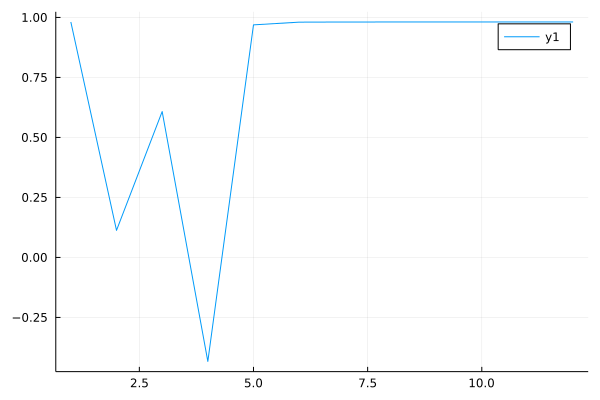

In [12]:
plot(sol.trace)

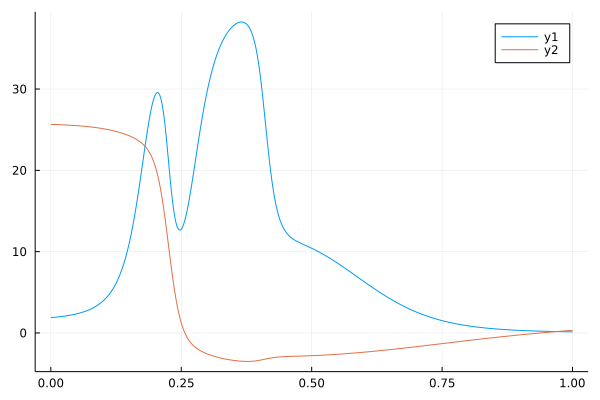

In [13]:
Ω(t) = sigmoid(ann([t], sol.params)[1])
Δ(t) = ann([t], sol.params)[2]

ts = t0:0.001:t1
f = plot(ts, Ω.(ts))
plot!(f, ts, Δ.(ts))